In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf


# representative dataset for TFLite conversion
def representative_data_gen():
    dataset_path = "processed_dataset/train"

    if not os.path.exists(dataset_path):
        raise ValueError(f"Dataset path '{dataset_path}' does not exist!")

    class_dirs = [
        os.path.join(dataset_path, cls)
        for cls in os.listdir(dataset_path)
        if os.path.isdir(os.path.join(dataset_path, cls))
    ]
    image_paths = []

    for cls_dir in class_dirs:
        images = [
            os.path.join(cls_dir, img)
            for img in os.listdir(cls_dir)
            if img.lower().endswith((".jpg", ".png", ".jpeg"))
        ]
        image_paths.extend(images)

    if len(image_paths) == 0:
        raise ValueError("No images found in the dataset!")

    for img_path in image_paths:
        image = cv2.imread(img_path)
        if image is None:
            print(f"Skipping corrupted image: {img_path}")
            continue
        image = image.astype(np.float32) / 255.0
        yield [np.expand_dims(image, axis=0)]


# convert .keras to .tfite with Float16 Weights & Int8 Activations
def convert_to_tflite(
    model_path="app/models/20FrozenLayersRotationFlip.keras",
    output_tflite="app/models/20FrozenLayersRotationFlip.tflite",
):

    # load Keras model
    model = tf.keras.models.load_model(model_path)

    # init the TFLite converter
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]

    # Use sample training data for activation quantization
    converter.representative_dataset = representative_data_gen

    # Use float16 for weights to maintain accuracy
    converter.target_spec.supported_types = [tf.float16]

    # convert the model
    tflite_model = converter.convert()

    # save the quantized model
    with open(output_tflite, "wb") as f:
        f.write(tflite_model)

    print(f"TFLite quantized model saved as: {output_tflite}")


convert_to_tflite()

INFO:tensorflow:Assets written to: /var/folders/3w/7743sr6s6qg2nrcjw5n8343c0000gn/T/tmp312a2l_s/assets


INFO:tensorflow:Assets written to: /var/folders/3w/7743sr6s6qg2nrcjw5n8343c0000gn/T/tmp312a2l_s/assets


Saved artifact at '/var/folders/3w/7743sr6s6qg2nrcjw5n8343c0000gn/T/tmp312a2l_s'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 26), dtype=tf.float32, name=None)
Captures:
  14280872704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14290731072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14290732128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14280873232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14280875872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14290734944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14290780400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14290780576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14290760096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14290762912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1429078321

W0000 00:00:1743159644.277349 4912876 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1743159644.277760 4912876 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1743159644.359255 4912876 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled


TFLite Model expects input of type: <class 'numpy.float32'>
TFLite Model Accuracy: 0.9953

Classification Report

              precision    recall  f1-score   support

           A     1.0000    1.0000    1.0000       123
           B     1.0000    1.0000    1.0000       115
           C     1.0000    0.9924    0.9962       131
           D     0.9908    0.9908    0.9908       109
           E     1.0000    1.0000    1.0000        98
           F     1.0000    1.0000    1.0000       113
           G     1.0000    1.0000    1.0000       128
           H     0.9841    1.0000    0.9920       124
           I     1.0000    0.9813    0.9906       107
           J     1.0000    1.0000    1.0000       115
           K     0.9917    0.9917    0.9917       120
           L     1.0000    1.0000    1.0000       114
           M     0.9903    1.0000    0.9951       102
           N     0.9919    1.0000    0.9960       123
           O     1.0000    0.9915    0.9957       117
           P     1.00

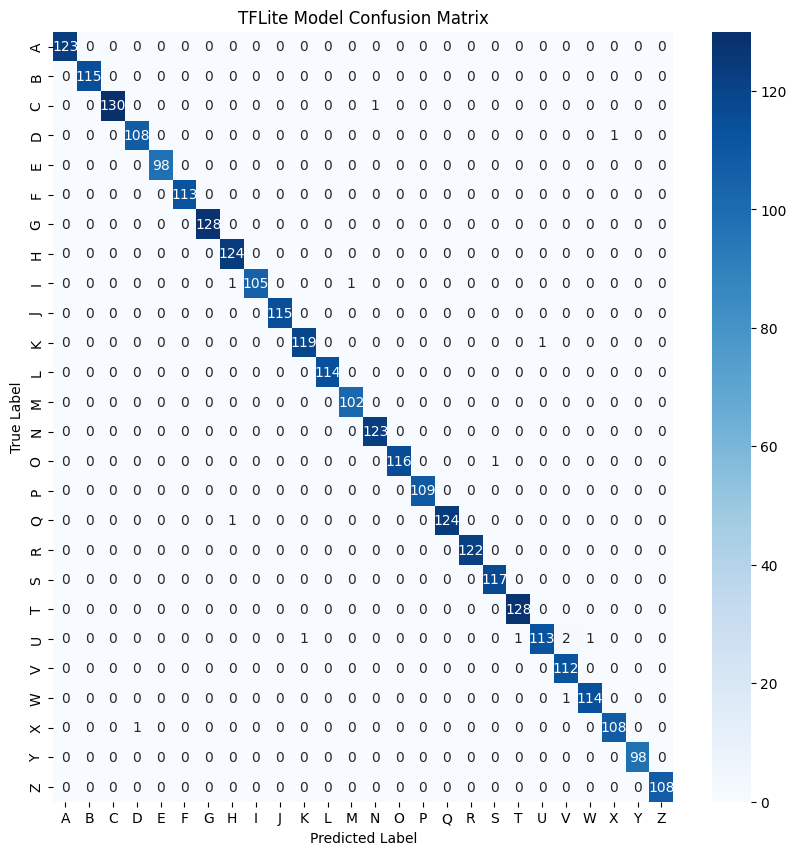

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


def evaluate_tflite_model(tflite_model_path, test_dataset_path):
    # load TFLite model
    interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # check expected data type
    input_dtype = input_details[0]["dtype"]
    print(f"TFLite Model expects input of type: {input_dtype}")

    # get class labels
    class_labels = sorted(
        [
            d
            for d in os.listdir(test_dataset_path)
            if os.path.isdir(os.path.join(test_dataset_path, d))
        ]
    )
    image_paths, true_labels = [], []
    for class_idx, class_name in enumerate(class_labels):
        class_dir = os.path.join(test_dataset_path, class_name)
        for img_file in os.listdir(class_dir):
            if img_file.lower().endswith((".jpg", ".png", ".jpeg")):
                image_paths.append(os.path.join(class_dir, img_file))
                true_labels.append(class_idx)

    # initialize prediction lists
    tflite_predictions = []

    for img_path in image_paths:
        image = cv2.imread(img_path)
        if image is None:
            print(f"Skipping corrupted image: {img_path}")
            continue

        # normalize and add batch dimension
        image = image.astype(np.float32) / 255.0
        image = np.expand_dims(image, axis=0)

        # TFLite Prediction
        interpreter.set_tensor(input_details[0]["index"], image)
        interpreter.invoke()
        tflite_pred = interpreter.get_tensor(output_details[0]["index"])
        tflite_predictions.append(np.argmax(tflite_pred))

    # convert to numpy arrays
    true_labels = np.array(true_labels)
    tflite_predictions = np.array(tflite_predictions)

    #  accuracy
    tflite_acc = np.mean(tflite_predictions == true_labels)

    print(f"TFLite Model Accuracy: {tflite_acc:.4f}")

    # classification report
    tflite_report = classification_report(
        true_labels, tflite_predictions, target_names=class_labels, digits=4
    )

    print("\nClassification Report\n")
    print(tflite_report)

    #  confusion matrix
    plot_confusion_matrix(
        confusion_matrix(true_labels, tflite_predictions),
        class_labels,
        "TFLite Model Confusion Matrix",
    )


def plot_confusion_matrix(cm, class_names, title="Confusion Matrix"):
    plt.figure(figsize=(10, 10))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()


evaluate_tflite_model(
    tflite_model_path="app/models/20FrozenLayersRotationFlip.tflite",
    test_dataset_path="processed_dataset/test",
)